In [1]:
import sys
import os
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print(f"Project Root added: '{project_root}'")

Project Root added: 'd:\VNUK ASSIGNMENTS\3rd YEAR\1st SEM\AI\deepfake-detection\deep_fake_detection'


In [2]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
from src.preprocessing import get_transforms

In [3]:
def flip_label(y):
    return 1 - y

In [4]:
def get_dataloaders(root_dir, model_name, batch_size=32):
    """
    Args:
        root_dir: Should point to 'data/images' containing 'train' and 'val' folders.
    """
    # Define path
    train_dir = os.path.join(root_dir, 'train')
    valid_dir = os.path.join(root_dir, 'val')
    
    # Transforms
    transform = get_transforms(model_name)
    
    # Create Dataset with ImageFolder
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform, target_transform=flip_label)
    valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform, target_transform=flip_label)
    
    print(f"Classes found: {train_dataset.class_to_idx}")
    print("APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.")
    
    # Loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True)
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True)
    
    return train_loader, valid_loader

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from src.model import SimpleCNN
from src.utils import set_seed, train_one_epoch, evaluate, save_checkpoint, save_experiment_json

## **Configurations**

In [6]:
DATA_ROOT = '../data/images'
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [7]:
print(f"Device using: {DEVICE}")

Device using: cuda


In [8]:
MODEL_NAME = 'simpleCNN'
TASK_NAME = 'deepfake_detection'

In [9]:
set_seed(42)

## **Preparation**

In [10]:
train_loader, valid_loader = get_dataloaders(DATA_ROOT, MODEL_NAME, BATCH_SIZE)
print(f"- Train batches: {len(train_loader)}\n- Valid batches: {len(valid_loader)}")

Classes found: {'fake': 0, 'real': 1}
APPLYING LABEL FLIP: Mapped 'fake'-> 1 and 'real'-> 0 internally.
- Train batches: 750
- Valid batches: 125


## **Model Setup**

In [11]:
model = SimpleCNN(num_classes=2).to(DEVICE)

In [12]:
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=16, bias=True)
  (leakly_relu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-8)

In [14]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

## **Training**

In [15]:
for epoch in range(EPOCHS):
    # Train
    train_acc, train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    
    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.04it/s]


[1/30] train_acc: 0.5623 - train_loss: 0.6864 - valid_acc: 0.6192 - valid_loss: 0.6641
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 1 - acc: 0.6192



Evaluating: 100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


[2/30] train_acc: 0.6024 - train_loss: 0.6591 - valid_acc: 0.6228 - valid_loss: 0.6386
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 2 - acc: 0.6228



Evaluating: 100%|██████████| 125/125 [00:38<00:00,  3.24it/s]


[3/30] train_acc: 0.6189 - train_loss: 0.6457 - valid_acc: 0.6382 - valid_loss: 0.6316
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 3 - acc: 0.6382



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.69it/s]


[4/30] train_acc: 0.6318 - train_loss: 0.6318 - valid_acc: 0.6435 - valid_loss: 0.6297
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 4 - acc: 0.6435



Evaluating: 100%|██████████| 125/125 [00:25<00:00,  4.88it/s]


[5/30] train_acc: 0.6432 - train_loss: 0.6201 - valid_acc: 0.6545 - valid_loss: 0.6214
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 5 - acc: 0.6545



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.10it/s]


[6/30] train_acc: 0.6576 - train_loss: 0.6034 - valid_acc: 0.6683 - valid_loss: 0.5996
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 6 - acc: 0.6683



Evaluating: 100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


[7/30] train_acc: 0.6729 - train_loss: 0.5862 - valid_acc: 0.6735 - valid_loss: 0.5960
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 7 - acc: 0.6735



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  5.98it/s]


[8/30] train_acc: 0.6858 - train_loss: 0.5667 - valid_acc: 0.6735 - valid_loss: 0.6328
	- [current best] epoch: 7 - acc: 0.6735



Evaluating: 100%|██████████| 125/125 [00:38<00:00,  3.23it/s]


[9/30] train_acc: 0.7039 - train_loss: 0.5487 - valid_acc: 0.6767 - valid_loss: 0.6391
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 9 - acc: 0.6767



Evaluating: 100%|██████████| 125/125 [00:44<00:00,  2.84it/s]


[10/30] train_acc: 0.7207 - train_loss: 0.5296 - valid_acc: 0.6965 - valid_loss: 0.5870
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 10 - acc: 0.6965



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.39it/s]


[11/30] train_acc: 0.7360 - train_loss: 0.5078 - valid_acc: 0.7050 - valid_loss: 0.5843
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 11 - acc: 0.7050



Evaluating: 100%|██████████| 125/125 [00:42<00:00,  2.97it/s]


[12/30] train_acc: 0.7551 - train_loss: 0.4829 - valid_acc: 0.7063 - valid_loss: 0.6278
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 12 - acc: 0.7063



Evaluating: 100%|██████████| 125/125 [00:30<00:00,  4.13it/s]


[13/30] train_acc: 0.7638 - train_loss: 0.4676 - valid_acc: 0.7047 - valid_loss: 0.5752
	- [current best] epoch: 12 - acc: 0.7063



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.53it/s]


[14/30] train_acc: 0.7780 - train_loss: 0.4478 - valid_acc: 0.7027 - valid_loss: 0.6403
	- [current best] epoch: 12 - acc: 0.7063



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.54it/s]


[15/30] train_acc: 0.7866 - train_loss: 0.4333 - valid_acc: 0.7153 - valid_loss: 0.6585
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 15 - acc: 0.7153



Evaluating: 100%|██████████| 125/125 [00:26<00:00,  4.69it/s]


[16/30] train_acc: 0.7951 - train_loss: 0.4158 - valid_acc: 0.7262 - valid_loss: 0.5952
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 16 - acc: 0.7262



Evaluating: 100%|██████████| 125/125 [00:26<00:00,  4.68it/s]


[17/30] train_acc: 0.8060 - train_loss: 0.3993 - valid_acc: 0.7175 - valid_loss: 0.6321
	- [current best] epoch: 16 - acc: 0.7262



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.77it/s]


[18/30] train_acc: 0.8161 - train_loss: 0.3848 - valid_acc: 0.7135 - valid_loss: 0.6676
	- [current best] epoch: 16 - acc: 0.7262



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.04it/s]


[19/30] train_acc: 0.8211 - train_loss: 0.3749 - valid_acc: 0.7240 - valid_loss: 0.6815
	- [current best] epoch: 16 - acc: 0.7262



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.33it/s]


[20/30] train_acc: 0.8275 - train_loss: 0.3645 - valid_acc: 0.7235 - valid_loss: 0.6559
	- [current best] epoch: 16 - acc: 0.7262



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.34it/s]


[21/30] train_acc: 0.8338 - train_loss: 0.3523 - valid_acc: 0.7305 - valid_loss: 0.6622
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 21 - acc: 0.7305



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.11it/s]


[22/30] train_acc: 0.8403 - train_loss: 0.3429 - valid_acc: 0.7027 - valid_loss: 0.7780
	- [current best] epoch: 21 - acc: 0.7305



Evaluating: 100%|██████████| 125/125 [00:22<00:00,  5.60it/s]


[23/30] train_acc: 0.8369 - train_loss: 0.3450 - valid_acc: 0.7338 - valid_loss: 0.6518
Checkpoint saved: ../results/best_simpleCNN.pth
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:24<00:00,  5.09it/s]


[24/30] train_acc: 0.8490 - train_loss: 0.3213 - valid_acc: 0.7188 - valid_loss: 0.7525
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.29it/s]


[25/30] train_acc: 0.8533 - train_loss: 0.3105 - valid_acc: 0.7265 - valid_loss: 0.7205
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


[26/30] train_acc: 0.8569 - train_loss: 0.3094 - valid_acc: 0.7133 - valid_loss: 0.7975
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.12it/s]


[27/30] train_acc: 0.8651 - train_loss: 0.2968 - valid_acc: 0.6950 - valid_loss: 0.9078
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.84it/s]


[28/30] train_acc: 0.8009 - train_loss: 0.4090 - valid_acc: 0.7292 - valid_loss: 0.7719
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.30it/s]


[29/30] train_acc: 0.8667 - train_loss: 0.2899 - valid_acc: 0.7160 - valid_loss: 0.8143
	- [current best] epoch: 23 - acc: 0.7338



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]

[30/30] train_acc: 0.8702 - train_loss: 0.2800 - valid_acc: 0.7300 - valid_loss: 0.8047
	- [current best] epoch: 23 - acc: 0.7338



In [16]:
json_filename = f"../results/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/simpleCNN_deepfake_detection.json


## **Performance Evaluation**

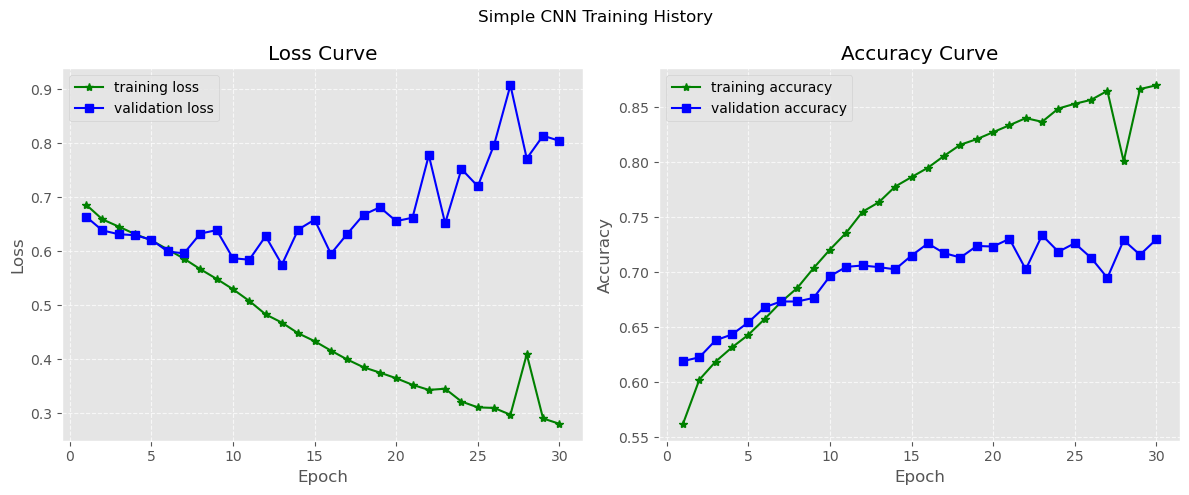

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("Simple CNN Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].grid(True, linestyle='--', alpha=0.7)

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
ax[1].grid(True, linestyle='--', alpha=0.7)

img_save = f"../results/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def get_all_predictions(model, loader, device):
    """
    Runs inference on the entire loader and returns all true labels and predictions.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Getting Predictions"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return all_labels, all_preds

def plot_confusion_matrix_heatmap(y_true, y_pred, class_names=['Real', 'Fake']):
    """
    Generates and plots a confusion matrix heatmap.
    """
    import matplotlib.pyplot as plt
    plt.style.use('ggplot')   
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    img_save = f"../results/{MODEL_NAME}_{TASK_NAME}_cfm.png"
    plt.savefig(img_save)
    plt.show()

In [25]:
from sklearn.metrics import accuracy_score
y_true, y_pred = get_all_predictions(model, valid_loader, DEVICE)
acc = accuracy_score(y_true, y_pred)

print(f"Simple CNN Accuracy: {acc:.4f}")

Getting Predictions: 100%|██████████| 125/125 [00:23<00:00,  5.21it/s]

Simple CNN Accuracy: 0.7300


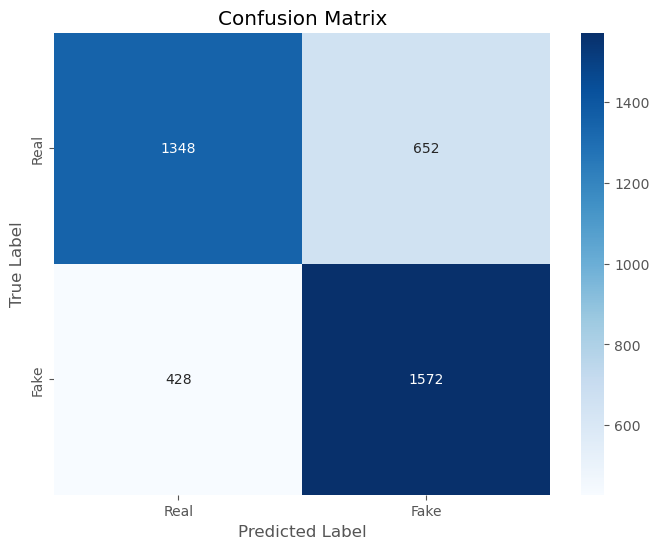

In [27]:
model.to(DEVICE)
plot_confusion_matrix_heatmap(y_true, y_pred, class_names=['Real', 'Fake'])